In [1]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")
data_dir = "../"

# Service Startup

This data visualizes the necessary time of starting up and shutting down of containers using the resource manager. Each time measurement consisted of creating a deployment with 1, 4, 12, 24, 36, 48 or 60 services and then calling the startup and shutdown routes of the resource manager for all services of the current deployment to create the k8s deployments/services on the target resource. Additionally, the procedure of starting up and shutting down a service has been implemented using the python k8s client library. The previously described time measurements have also been done using the python implementation and act as baseline for the results.
Following setups where tested:
K8S (resource 4) with 1, 4, 12, 24, 36, 48 and 60 concurrent startups/shutdowns

The original data can be found in [reaction_time](../service_startup)

In [2]:
fi_rtt = []
fi_dir = os.path.join(data_dir, "service_startup")

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(fi_dir + '/si_1.csv')

# Separate entries for 'rm' and 'k8s'
rm_df = df[df['system'] == 'rm'].rename(columns={'round trip time (ms)': 'rm-round trip time (ms)'})
k8s_df = df[df['system'] == 'k8s'].rename(columns={'round trip time (ms)': 'k8s-round trip time(ms)'})

# Merge 'rm' and 'k8s' entries based on 'test-run' and 'type'
#merged_df = pd.merge(rm_df, k8s_df, on=['test-run', 'type']).groupby('type').mean()
merged_df = pd.merge(rm_df, k8s_df, on=['test-run', 'type']).drop(['test-run','system_x', 'system_y'], axis=1, inplace=False)
merged_df = merged_df.groupby('type').mean().reset_index()
merged_df['invocations'] = 1
merged_df

,type,rm-round trip time (ms),k8s-round trip time(ms),invocations
0,start,10263.913711,2552.926461,1
1,stop,3507.424513,42.975028,1


In [3]:
si_rtt = []
fi_dir = os.path.join(data_dir, "service_startup")

for file_path in glob.glob(fi_dir + "/*.csv"):
       df = pd.read_csv(file_path)
       rm_df = df[df['system'] == 'rm'].rename(columns={'round trip time (ms)': 'rm-round trip time (ms)'})
       k8s_df = df[df['system'] == 'k8s'].rename(columns={'round trip time (ms)': 'k8s-round trip time (ms)'})
       merged_df = pd.merge(rm_df, k8s_df, on=['test-run', 'type']).drop(['test-run','system_x', 'system_y'], axis=1, inplace=False)
       merged_df = merged_df.groupby('type').mean().reset_index()
       filename = os.path.basename(file_path)
       parts = filename.split('_')
       invocations = parts[1].split('.')[0]
       merged_df['invocations'] = int(invocations)
       si_rtt.append(merged_df)
       

means_df = pd.concat(si_rtt, ignore_index=True)
means_df['mean_diff'] = means_df['rm-round trip time (ms)'] - means_df['k8s-round trip time (ms)']
means_df['rm-round trip time (s)'] = means_df['rm-round trip time (ms)'] / 1000
means_df['k8s-round trip time (s)'] = means_df['k8s-round trip time (ms)'] / 1000
means_df

,type,rm-round trip time (ms),k8s-round trip time (ms),invocations,mean_diff,rm-round trip time (s),k8s-round trip time (s)
0,start,10263.913711,2552.926461,1,7710.987250,10.263914,2.552926
1,stop,3507.424513,42.975028,1,3464.449485,3.507425,0.042975
2,start,26828.926881,8303.419908,12,18525.506973,26.828927,8.303420
3,stop,14458.682775,149.565856,12,14309.116920,14.458683,0.149566
4,start,50799.121857,12679.393689,24,38119.728168,50.799122,12.679394
5,stop,31491.617521,236.981471,24,31254.636049,31.491618,0.236981
6,start,77045.714060,19236.836910,36,57808.877150,77.045714,19.236837
7,stop,54881.518126,426.272074,36,54455.246051,54.881518,0.426272
8,start,16907.392740,4552.801053,4,12354.591688,16.907393,4.552801
9,stop,5960.213502,68.489154,4,5891.724348,5.960214,0.068489


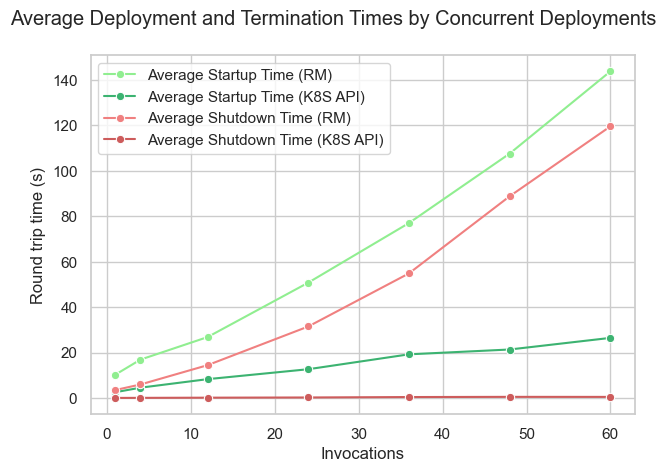

In [4]:
y_min = 0
sns.lineplot(data=means_df[means_df['type']=='start'], x='invocations', y='rm-round trip time (s)', label='Average Startup Time (RM)', marker='o', color='lightgreen')
sns.lineplot(data=means_df[means_df['type']=='start'], x='invocations', y='k8s-round trip time (s)', label='Average Startup Time (K8S API)', marker='o', color='mediumseagreen')
sns.lineplot(data=means_df[means_df['type']=='stop'], x='invocations', y='rm-round trip time (s)', label='Average Shutdown Time (RM)', marker='o', color='lightcoral')
sns.lineplot(data=means_df[means_df['type']=='stop'], x='invocations', y='k8s-round trip time (s)', label='Average Shutdown Time (K8S API)', marker='o', color='indianred')
plt.suptitle('Average Deployment and Termination Times by Concurrent Deployments')
plt.xlabel('Invocations')
plt.ylabel('Round trip time (s)')
plt.tight_layout()
plt.show()